# HNLQ: Part-02

This series of notebook demonstrates hierarchical nested lattice quantization using the D4 lattice, showing how multi-level quantization can improve rate-distortion performance.

In part-02, we will do sanity checks for overloading.

In [1]:
import sys
sys.path.append('../../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gemvq.quantizers.hnlq import HNLQ as HNLQ
from gemvq.quantizers.hnlq import HNLQConfig as QuantizerConfig


In [2]:
%load_ext autoreload
%autoreload 2

An important observation. In terms API and implementation HNLQ and NLQ are very similar. In fact, NLQ is special case of HNLQ with M=1.  Therefore, whatever we observed for NLQ, we should observe for NLQ with M=1.

The NLQ API is a strict subset of HNLQ API. That is what we will see below, as sanity check.

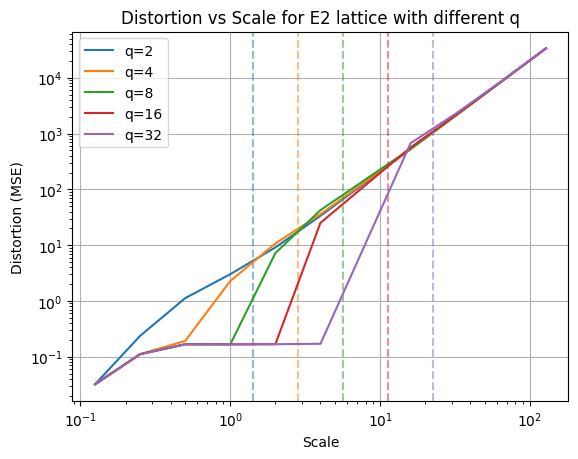

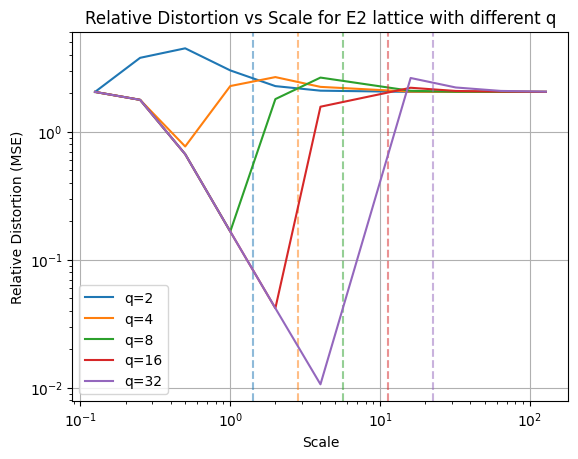

In [4]:
def run_norm_experiments(q,scale,overload, colors,beta,alpha, normalize,with_tie_dither):
    results = np.zeros((len(q), len(scale))) # distortion, rate
    results_rel = np.zeros((len(q), len(scale))) # distortion, rate
    x_prenorm = np.random.randn(1000,2)
    if normalize:
        x_prenorm = x_prenorm/np.sqrt(np.linalg.norm(x_prenorm, axis=1, keepdims=True))
        #x_prenorm = x_prenorm/np.sqrt(2) # average norm is sqrt(2)
    for i, qi in enumerate(q):    
        quantizer = HNLQ.create_z2_quantizer(q=qi, M=1, overload=overload,beta=beta,alpha=alpha,with_tie_dither=with_tie_dither) 
        for j, si in enumerate(scale):
            x = x_prenorm*si
            # do batch encoding
            b_enc, b_T = quantizer.batch_encode(x)
            # do batch decoding
            x_q = quantizer.batch_decode(b_enc, b_T)
            # compute distortion and rate
            distortion = np.mean(np.linalg.norm(x-x_q, axis=1)**2)
            results[i,j] = distortion
            results_rel[i,j] = distortion/(si**2)
    for i, qi in enumerate(q):
        plt.plot(scale, results[i,:], label=f'q={qi}', color=colors[qi])
        plt.axvline(qi/np.sqrt(2), color=colors[qi], linestyle='--', alpha=0.5)
    
    plt.ylabel('Distortion (MSE)')
    plt.xlabel('Scale')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Distortion vs Scale for E2 lattice with different q')
    plt.legend()
    plt.grid()
    plt.show()

    for i, qi in enumerate(q):
        plt.plot(scale, results_rel[i,:], label=f'q={qi}', color=colors[qi])
        plt.axvline(qi/np.sqrt(2), color=colors[qi], linestyle='--', alpha=0.5)
    
    plt.ylabel('Relative Distortion (MSE)')
    plt.xlabel('Scale')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Relative Distortion vs Scale for E2 lattice with different q')
    plt.legend()
    plt.grid()
    plt.show()


q = [2,4,8,16,32]
colors = {2: 'tab:blue', 4: 'tab:orange', 8: 'tab:green', 16: 'tab:red', 32: 'tab:purple'}
scale = [0.125,0.25,0.5,1,2,4,16,32,64,128]
overload = False
beta = 1
alpha = 1
normalize = False
with_tie_dither = False
run_norm_experiments(q,scale,overload,colors,beta,alpha, normalize,with_tie_dither)


With configuration mananger, we can generalize this to support multiple lattices.

In [ ]:
import re

def run_norm_experiments(q_values, scale_values, colors, base_config=None, normalize=False, n_samples=1000):
    """
    Run normalization experiments using HNLQConfig for parameter management.
    
    Parameters:
    -----------
    q_values : list
        List of quantization parameters to test
    scale_values : list
        List of scale factors to test
    colors : dict
        Color mapping for each q value
    base_config : HNLQConfig, optional
        Base configuration to use. If None, creates default Z2 config
    normalize : bool, optional
        Whether to normalize input vectors. Default is False
    n_samples : int, optional
        Number of random samples to generate. Default is 1000
    """
    # Create base configuration if not provided
    if base_config is None:
        base_config = QuantizerConfig(
            lattice_type='Z2',
            q=4,  # Will be overridden for each q
            M=1,
            beta=1.0,
            alpha=1.0,
            overload=False,
            with_tie_dither=False
        )
    d = int(re.sub(r'[A-Z]', '', lattice_type.upper()))
    results = np.zeros((len(q_values), d))
    results_rel = np.zeros((len(q_values), len(scale_values)))
    
    # Generate base data
    x_prenorm = np.random.randn(n_samples, len(base_config.))
    if normalize:
        x_prenorm = x_prenorm / np.sqrt(np.linalg.norm(x_prenorm, axis=1, keepdims=True))
    
    # Run experiments for each q value
    for i, qi in enumerate(q_values):
        # Create config for this q value by copying base config
        config = QuantizerConfig(
            lattice_type=base_config.lattice_type,
            q=qi,
            M=base_config.M,
            beta=base_config.beta,
            alpha=base_config.alpha,
            eps=base_config.eps,
            overload=base_config.overload,
            decoding=base_config.decoding,
            max_scaling_iterations=base_config.max_scaling_iterations,
            with_tie_dither=base_config.with_tie_dither,
            with_dither=base_config.with_dither
        )
        
        # Create quantizer with this config
        quantizer = HNLQ(config)
        
        # Test each scale value
        for j, si in enumerate(scale_values):
            x = x_prenorm * si
            
            # Do batch encoding and decoding
            b_enc, b_T = quantizer.batch_encode(x)
            x_q = quantizer.batch_decode(b_enc, b_T)
            
            # Compute distortion
            distortion = np.mean(np.linalg.norm(x - x_q, axis=1) ** 2)
            results[i, j] = distortion
            results_rel[i, j] = distortion / (si ** 2)
    
    # Plot absolute distortion
    for i, qi in enumerate(q_values):
        plt.plot(scale_values, results[i, :], label=f'q={qi}', color=colors[qi])
        plt.axvline(qi/np.sqrt(2), color=colors[qi], linestyle='--', alpha=0.5)
    
    plt.ylabel('Distortion (MSE)')
    plt.xlabel('Scale')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Distortion vs Scale for Z2 lattice with different q')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot relative distortion
    for i, qi in enumerate(q_values):
        plt.plot(scale_values, results_rel[i, :], label=f'q={qi}', color=colors[qi])
        plt.axvline(qi/np.sqrt(2), color=colors[qi], linestyle='--', alpha=0.5)
    
    plt.ylabel('Relative Distortion (MSE)')
    plt.xlabel('Scale')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Relative Distortion vs Scale for Z2 lattice with different q')
    plt.legend()
    plt.grid()
    plt.show()
    
    return results, results_rel

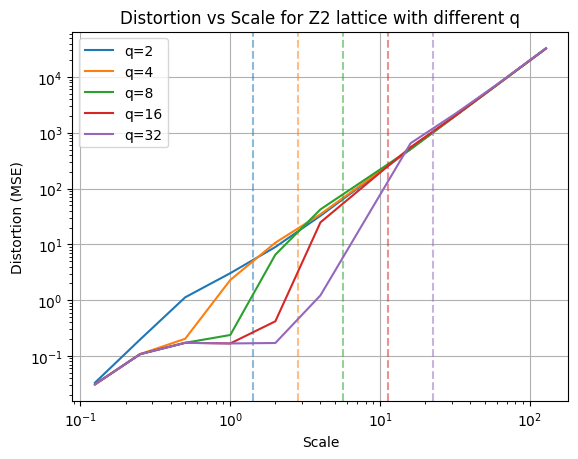

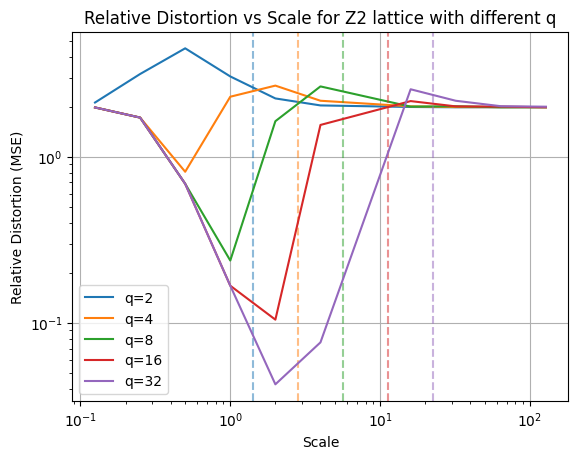

In [12]:
# Create a base configuration
base_config = QuantizerConfig(
    lattice_type='Z2',
    q=4,  # This will be overridden for each q value
    M=1,
    beta=1.0,
    alpha=1.0,
    overload=False,
    with_tie_dither=False
)

# Define parameters
q = [2, 4, 8, 16, 32]
colors = {2: 'tab:blue', 4: 'tab:orange', 8: 'tab:green', 16: 'tab:red', 32: 'tab:purple'}
scale = [0.125, 0.25, 0.5, 1, 2, 4, 16, 32, 64, 128]
lattice_type = 'Z2'
# Run experiments using the config manager
results, results_rel = run_norm_experiments(
    q_values=q,
    scale_values=scale,
    colors=colors,
    base_config=base_config,
    normalize=False,
    n_samples=1000
)

We get similar results to what we saw with NLQ, but here with HNLQ (M=1). Next, we will test D4 with better overloading method already implemented.

In [13]:
# Create a base configuration
base_config = QuantizerConfig(
    lattice_type='D4',
    q=2,  # This will be overridden for each q value
    M=1,
    beta=1.0,
    alpha=1.0,
    overload=True,
    with_tie_dither=True
)

# Define parameters
q = [2, 4, 8, 16, 32]
colors = {2: 'tab:blue', 4: 'tab:orange', 8: 'tab:green', 16: 'tab:red', 32: 'tab:purple'}
scale = [0.125, 0.25, 0.5, 1, 2, 4, 16, 32, 64, 128]

# Run experiments using the config manager
results, results_rel = run_norm_experiments(
    q_values=q,
    scale_values=scale,
    colors=colors,
    base_config=base_config,
    normalize=False,
    n_samples=1000
)

ValueError: operands could not be broadcast together with shapes (2,) (4,) 